In [1]:
#导入MindSpore模块和辅助模块：

import os
import csv
import numpy as np

import mindspore as ms
from mindspore import nn, context, dataset 
from mindspore.train import LossMonitor

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

In [2]:
#读取Iris数据集`iris.data`，并作检查
with open('iris.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[0:5]); print(data[50:55]); print(data[100:105]) # 打印部分数据

[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'], ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa'], ['4.7', '3.2', '1.3', '0.2', 'Iris-setosa'], ['4.6', '3.1', '1.5', '0.2', 'Iris-setosa'], ['5.0', '3.6', '1.4', '0.2', 'Iris-setosa']]
[['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor'], ['6.4', '3.2', '4.5', '1.5', 'Iris-versicolor'], ['6.9', '3.1', '4.9', '1.5', 'Iris-versicolor'], ['5.5', '2.3', '4.0', '1.3', 'Iris-versicolor'], ['6.5', '2.8', '4.6', '1.5', 'Iris-versicolor']]
[['6.3', '3.3', '6.0', '2.5', 'Iris-virginica'], ['5.8', '2.7', '5.1', '1.9', 'Iris-virginica'], ['7.1', '3.0', '5.9', '2.1', 'Iris-virginica'], ['6.3', '2.9', '5.6', '1.8', 'Iris-virginica'], ['6.5', '3.0', '5.8', '2.2', 'Iris-virginica']]


In [3]:
#数据集的3类样本共150条，将样本的4个属性作为自变量$X$，将样本的3个类别映射为{0, 1, 2}，作为因变量$Y$。
label_map = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
X = np.array([[float(x) for x in s[:-1]] for s in data[:150]], np.float32)
print(X[0])
Y = np.array([label_map[s[-1]] for s in data[:150]], np.int32)
print(Y[0])

[5.1 3.5 1.4 0.2]
0


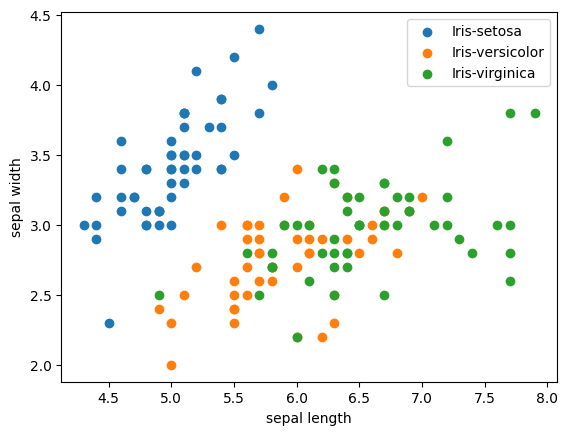

In [4]:
#取样本的前两个属性进行2维可视化，可以看到在前两个属性上其中一类和余下两类是线性可分的，而余下两类之间线性不可分。
from matplotlib import pyplot as plt
plt.scatter(X[:50, 0], X[:50, 1], label='Iris-setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], label='Iris-versicolor')
plt.scatter(X[100:, 0], X[100:, 1], label='Iris-virginica')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [5]:
#将数据集按8:2划分为训练集和验证集
train_idx = np.random.choice(150, 120, replace=False)
print(train_idx)
test_idx = np.array(list(set(range(150)) - set(train_idx)))
print(test_idx)
X_train, Y_train = X[train_idx], Y[train_idx]
print(X_train, Y_train)
X_test, Y_test = X[test_idx], Y[test_idx]
print(X_test, Y_test)

[ 42 109  81  98  89  53   5  11  23 130 104  13  95  10 105 129  83  39
 107  57 115  36  91  62  24 117 116 135  19 106  77  84  92  72  82  58
  20  21  54  46  25 146 127  85 128  74  52 148 142  56  55 123  18  93
  67 111  79   3 110  73  14 102  78 114 126 136  43 145  44 141 121  37
  30 144 113   8  35 119  47  51 103  38  26 101  76  59 118  33  99  22
  16  69  45 147 143   1  12 124  90 112  94   7  70 131  29 140  28   4
  60  97  48  64  61   2  40  50 100   9  88  34]
[  0 132 133   6 134 137 138 139  15  17 149  27  31  32  41  49  63  65
  66  68  71  75  80  86  87  96 108 120 122 125]
[[4.4 3.2 1.3 0.2]
 [7.2 3.6 6.1 2.5]
 [5.5 2.4 3.7 1. ]
 [5.1 2.5 3.  1.1]
 [5.5 2.5 4.  1.3]
 [5.5 2.3 4.  1.3]
 [5.4 3.9 1.7 0.4]
 [4.8 3.4 1.6 0.2]
 [5.1 3.3 1.7 0.5]
 [7.4 2.8 6.1 1.9]
 [6.5 3.  5.8 2.2]
 [4.3 3.  1.1 0.1]
 [5.7 3.  4.2 1.2]
 [5.4 3.7 1.5 0.2]
 [7.6 3.  6.6 2.1]
 [7.2 3.  5.8 1.6]
 [6.  2.7 5.1 1.6]
 [5.1 3.4 1.5 0.2]
 [7.3 2.9 6.3 1.8]
 [4.9 2.4 3.3 1. ]
 [6.4 3.2

In [6]:
#使用MindSpore`GeneratorDataset`接口将numpy.ndarray类型的数据转换为Dataset
XY_train = list(zip(X_train, Y_train))
ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y'])
ds_train = ds_train.shuffle(buffer_size=120).batch(32, drop_remainder=True)

XY_test = list(zip(X_test, Y_test))
ds_test = dataset.GeneratorDataset(XY_test, ['x', 'y'])
ds_test = ds_test.batch(30)

In [7]:
net = nn.Dense(4, 3)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
opt = nn.Momentum(net.trainable_params(), learning_rate=0.05, momentum=0.9)


In [8]:
model = ms.train.Model(net, loss, opt, metrics={'acc', 'loss'})
model.train(25, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], dataset_sink_mode=False)
metrics = model.eval(ds_test)
print(metrics)

epoch: 1 step: 3, loss is 0.9638346433639526
epoch: 2 step: 3, loss is 0.7689021825790405
epoch: 3 step: 3, loss is 0.5731985569000244
epoch: 4 step: 3, loss is 0.48813751339912415
epoch: 5 step: 3, loss is 0.49116724729537964
epoch: 6 step: 3, loss is 0.36402812600135803
epoch: 7 step: 3, loss is 0.3886928856372833
epoch: 8 step: 3, loss is 0.3897549510002136
epoch: 9 step: 3, loss is 0.34571775794029236
epoch: 10 step: 3, loss is 0.33777377009391785
epoch: 11 step: 3, loss is 0.26373881101608276
epoch: 12 step: 3, loss is 0.19324469566345215
epoch: 13 step: 3, loss is 0.2507563829421997
epoch: 14 step: 3, loss is 0.2313857227563858
epoch: 15 step: 3, loss is 0.2600938081741333
epoch: 16 step: 3, loss is 0.35910099744796753
epoch: 17 step: 3, loss is 0.22504913806915283
epoch: 18 step: 3, loss is 0.1976485401391983
epoch: 19 step: 3, loss is 0.24704760313034058
epoch: 20 step: 3, loss is 0.1765996664762497
epoch: 21 step: 3, loss is 0.18856310844421387
epoch: 22 step: 3, loss is 0.162